# Objetivo: Regressão no dataset "Real estate valuation" (UCI), usando Perceptron Logístico.
    - Avaliação por validação cruzada k-fold e análise de resíduos.


In [1]:
import numpy as np
import pandas as pd

from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler

# Pacote do trabalho (funções utilitárias e modelos)
from trabalho_ic_aplicada.models import aux, reg_mlp


np.random.seed(42)


2025-08-10 18:30:33.405 | INFO     | trabalho_ic_aplicada.config:<module>:11 - PROJ_ROOT path is: /home/apo-note/Documents/Github/Trabalhos_IC_Aplicada


## [01] Carregamento do dataset e pré-processamento básico

In [2]:
real_estate_valuation = fetch_ucirepo(id=477)

# Nomes das variáveis (apenas informativo; a primeira é a data de transação)
features = real_estate_valuation.variables.iloc[1:, 0].values

# Matriz de atributos e vetor-alvo
X = real_estate_valuation.data.features.to_numpy()
y = real_estate_valuation.data.targets.to_numpy().ravel()

# Remove a 1ª coluna (data de transação), considerada não relevante
X = X[:, 1:]

# Índices dos folds para CV (k-fold estratificado não é essencial para regressão)
k_fold = aux.validacao_cruzada_kfold(X, y, k=10)

## [02] Hiperparâmetros e estruturas para coleta das métricas

- n_epocas: épocas de treinamento da MLP rala (camada de saída sigmoide)
- taxa_aprendizagem: passo constante (eta_i == eta_f)


In [3]:
n_epocas = 100
taxa_aprendizagem = 0.005

# Listas para métricas por fold (teste)
eqms_iqr = []
reqms_iqr = []
r_quadrados_iqr = []
hit_rates_20_iqr = []
hit_rates_10_iqr = []

# Correlações (treino/teste) por fold
correlacoes_treino = []
correlacoes_teste = []

# Para análises finais (resíduos/curvas de perda)
train_losses = []       # histórico de perda por fold
y_trains = []           # y verdadeiro (treino, todos folds)
y_train_preds = []      # y predito (treino, todos folds)
y_tests = []            # y verdadeiro (teste, todos folds)
y_test_preds = []       # y predito (teste, todos folds)


## [03] Loop de validação cruzada: treino, previsão e métricas por fold

Pré-processamento:
 - Features: QuantileTransformer (uniforme) para robustez a outliers
 - Alvo: MinMaxScaler para mapear y ∈ [0,1] (compatível com saída sigmoide)

Modelo:
 - MLP rala com camada de saída sigmoide (sem oculta: layer_sizes=[p,1])

Avaliação:
 - Métricas via aux.calcular_metricas e correlações de Pearson

In [4]:

for k in range(len(k_fold)):
    # Split por índices do fold k
    tr_idx, te_idx = k_fold[k]
    X_train_k = X[tr_idx, :]
    y_train_k = y[tr_idx].reshape(-1, 1)  # (n,1)
    X_test_k  = X[te_idx, :]
    y_test_k  = y[te_idx].reshape(-1, 1)

    # ---- Normalização das features (ajustar no treino, aplicar no teste)
    scaler_X = QuantileTransformer(
        n_quantiles=min(X_train_k.shape[0], 1000),  # limite prático
        output_distribution='uniform',
        random_state=42
    )
    X_train_k_norm = scaler_X.fit_transform(X_train_k)
    X_test_k_norm  = scaler_X.transform(X_test_k)

    # ---- Normalização do alvo para [0,1] (apenas com dados de treino)
    scaler_y = MinMaxScaler()
    y_train_k_norm = scaler_y.fit_transform(y_train_k)

    # ---- Treino da MLP rala (perceptron logístico para regressão)
    # layer_sizes: [n_features, 1] => sem camada oculta; ativações sigmoide
    weights, loss_history = reg_mlp.train_mlp_regression(
        X_train_k_norm,
        y_train_k_norm,
        layer_sizes=[X_train_k.shape[1], 1],
        epochs=n_epocas,
        eta_i=taxa_aprendizagem,
        eta_f=taxa_aprendizagem,
        hidden_activation='sigmoid',   # mantido para compatibilidade
        output_activation='sigmoid',
        verbose=False
    )
    train_losses.append(loss_history)

    # ---- Predição (treino) e desscala para o domínio original de y
    y_pred_train_norm = reg_mlp.predict_mlp_regression(
        X_train_k_norm, weights,
        hidden_activation='sigmoid',
        output_activation='sigmoid'
    )
    y_pred_train = scaler_y.inverse_transform(
        y_pred_train_norm.reshape(-1, 1)
    ).flatten()

    # Correlação no treino
    corr_treino = np.corrcoef(y_train_k.flatten(), y_pred_train)[0, 1]
    correlacoes_treino.append(corr_treino)

    # ---- Predição (teste) e desscala
    y_pred_test_norm = reg_mlp.predict_mlp_regression(
        X_test_k_norm, weights,
        hidden_activation='sigmoid',
        output_activation='sigmoid'
    )
    y_pred_test = scaler_y.inverse_transform(
        y_pred_test_norm.reshape(-1, 1)
    ).flatten()

    # Correlação no teste
    corr_teste = np.corrcoef(y_test_k.flatten(), y_pred_test)[0, 1]
    correlacoes_teste.append(corr_teste)

    # ---- Acumula para análises globais
    y_trains.extend(y_train_k.flatten())
    y_train_preds.extend(y_pred_train.flatten())
    y_tests.extend(y_test_k.flatten())
    y_test_preds.extend(y_pred_test.flatten())

    # ---- Métricas (teste) por fold
    # Nota: aux.calcular_metricas(y_true, y_pred, aux) retorna
    # (EQM, REQM, R2, hit@20%, hit@10%, residuos)
    eqm, reqm, r2, hit20, hit10, _ = aux.calcular_metricas(
        y_test_k.flatten(), y_pred_test, aux
    )
    eqms_iqr.append(eqm)
    reqms_iqr.append(reqm)
    r_quadrados_iqr.append(r2)
    hit_rates_20_iqr.append(hit20)
    hit_rates_10_iqr.append(hit10)

## [04] Consolidação, impressão de métricas e análise de resíduos

- Tabelas resumidas (médias/DP) via utilitários em aux.*
- Histograma de resíduos (treino) e dispersões (treino/teste)
- Curvas de perda por fold

Erro Quadrático Médio (EQM): 91.7239 ± 34.7189
Raiz do Erro Quadrático Médio (REQM): 9.4217 ± 1.7191
Hit rate 20%: 0.6272 ± 0.0728
Hit rate 10%: 0.3569 ± 0.0873

--- Coeficientes de Correlação (Real vs. Previsto) ---
Correlação Média (Treino): 0.7373 ± 0.0449
Correlação Média (Teste): 0.7212 ± 0.0678
Coeficiente de Determinação (R²): 0.5004 ± 0.0927

--- Análise de Gaussianidade dos Resíduos ---
Shapiro-Wilk (Treino): Estatística=0.9034, p-valor=0.0000
Shapiro-Wilk (Teste): Estatística=0.9096, p-valor=0.0000
Resíduos de treino NÃO seguem distribuição normal.


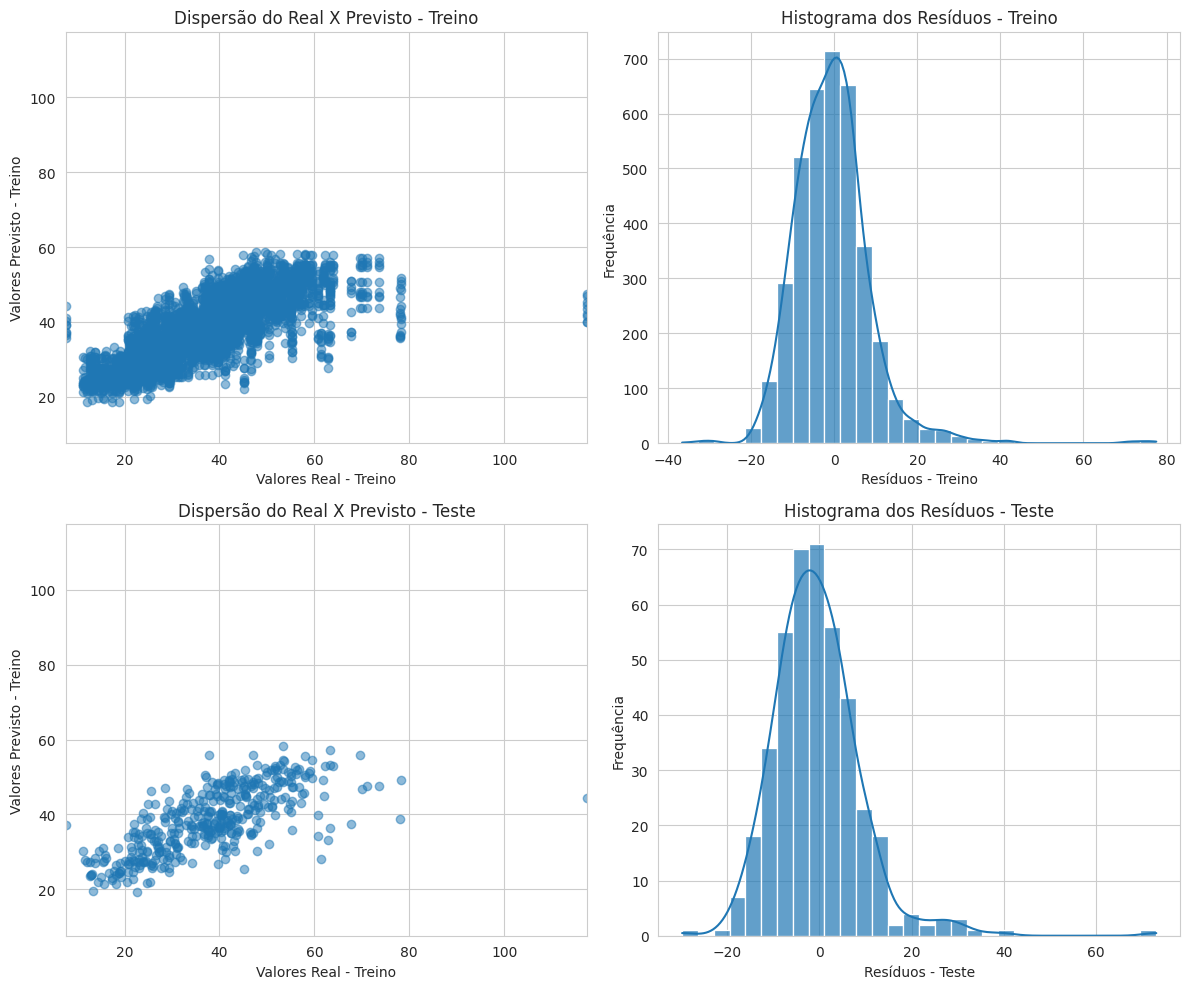

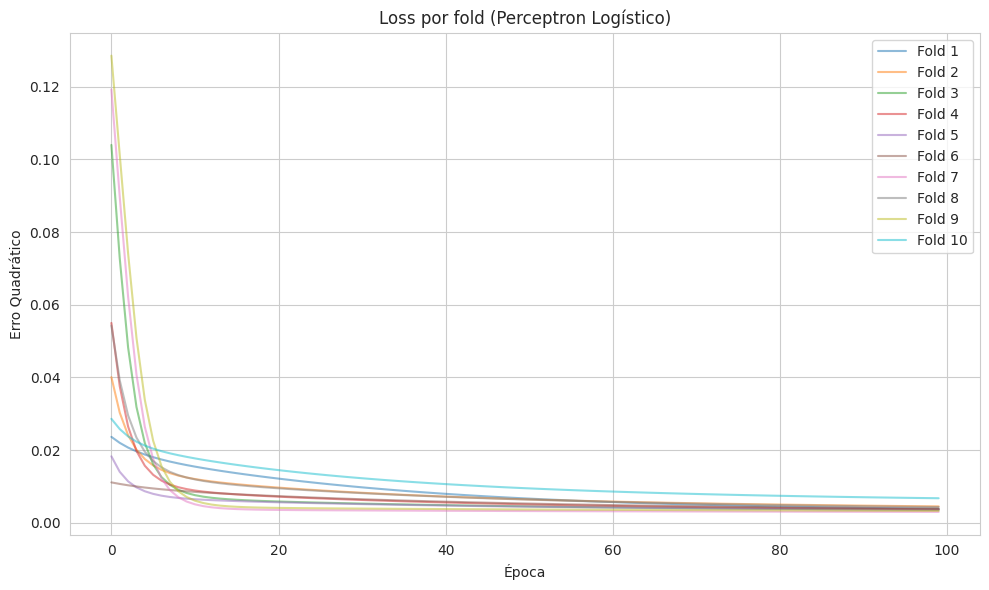

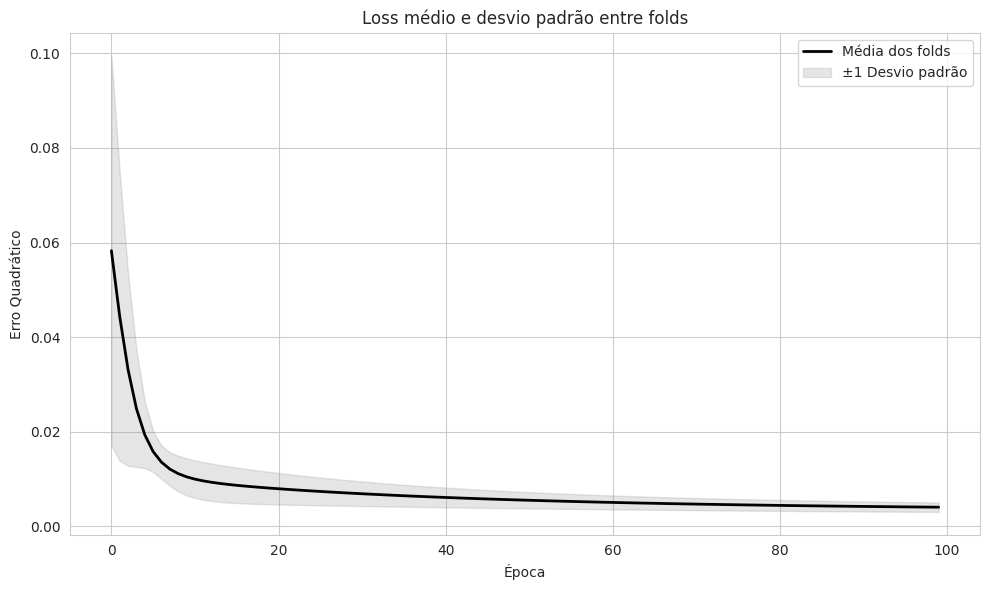

In [5]:

# Arrays para funções que esperam numpy
y_trains = np.array(y_trains)
y_train_preds = np.array(y_train_preds)
y_tests = np.array(y_tests)
y_test_preds = np.array(y_test_preds)

# ---- Resumos de métricas por fold (teste)
aux.imprimir_metricas(
    eqms_iqr, reqms_iqr, r_quadrados_iqr,
    hit_rates_20_iqr, hit_rates_10_iqr
)

# ---- Correlações (treino/teste) e R^2 (teste)
aux.imprimir_correlacoes(
    correlacoes_treino, correlacoes_teste, r_quadrados_iqr
)

# ---- Análise de resíduos e gráficos:
#     - Histograma dos resíduos (treino)
#     - Dispersões y_true vs y_pred (treino e teste)
aux.analisar_residuos(
    y_trains, y_train_preds,
    y_tests, y_test_preds,
    aux,
    titulo='Regressão Perceptron Logístico (saída sigmoide)'
)

# ---- Curvas de perda por fold
aux.plot_folds_loss(
    train_losses,
    titulo="Loss por fold (Perceptron Logístico)",
    ylabel="Erro Quadrático",
    xlabel="Época"
)